In [1]:
import os
from os.path import join
# Set working directory
os.chdir('/home/pedro/git2/gitflow/air_pollution_forecast')

import sys
sys.path.append('./eoas_pyutils')
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
import matplotlib.pyplot as plt
from torchsummary import summary
from conf.localConstants import constants
from proj_io.inout import (
    create_folder, add_previous_hours, get_column_names,
    read_merged_files, save_columns
)
# add_forecasted_hours,
from proj_preproc.preproc import loadScaler
from proj_prediction.prediction import  analyze_column
from pytorch_proj import (
    normalizeData, split_train_validation_and_test, apply_bootstrap, plot_forecast_hours
)

In [2]:
def filter_data(df, filter_type='none', filtered_pollutant='', filtered_station=''):
    """
    Filtra el DataFrame según el tipo de filtro especificado.
    Los posibles valores de filter_type son: 'none', 'single_pollutant', 'single_pollutant_and_station'
    """
    all_contaminant_columns, all_meteo_columns, all_time_colums = get_column_names(df)
    
    if filter_type == 'single_pollutant':
        filtered_pollutants = filtered_pollutant if isinstance(filtered_pollutant, list) else [filtered_pollutant]
        keep_cols = [x for x in df.columns if any(pollutant in x for pollutant in filtered_pollutants)]
        keep_cols += all_time_colums.tolist() + all_meteo_columns.tolist()
        
    elif filter_type == 'single_pollutant_and_station':
        keep_cols = [f'cont_{filtered_pollutant}_{filtered_station}'] + all_time_colums.tolist() + all_meteo_columns
    
    elif filter_type == 'none':
        return df.copy()

    print(f"Keeping columns: {len(keep_cols)} original columns: {len(df.columns)}")
    return df[keep_cols].copy()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hours_before = 0 #24
replace_nan_value = 0
data_folder = '/ZION/AirPollutionData/Data/'
grid_size = 4
merged_specific_folder = f'{grid_size*grid_size}'
input_folder = join(data_folder, 'MergedDataCSV/16/BK2/')
output_folder = join(data_folder, 'TrainingTestsPS2024')
norm_folder = join(output_folder, 'norm')
split_info_folder = join(output_folder, 'Splits')

val_perc = 0.1
test_perc = 0
epochs = 5000
batch_size = 5000
bootstrap = True
boostrap_factor = 15
boostrap_threshold = 2.9
model_name_user = 'TestPSpyt'
start_year = 2010
end_year = 2012
test_year = 2013
cur_pollutant = 'otres'
cur_station = 'MER'
forecasted_hours = 1
norm_type = 'meanzero var 1'
stations_2020 = [
    "UIZ", "AJU", "ATI", "CUA", "SFE", "SAG", "CUT", "PED", "TAH", "GAM", 
    "IZT", "CCA", "HGM", "LPR", "MGH", "CAM", "FAC", "TLA", "MER", "XAL", 
    "LLA", "TLI", "UAX", "BJU", "MPA", "MON", "NEZ", "INN", "AJM", "VIF"
]
stations = stations_2020
pollutants = "cont_otres"

In [4]:
folders = ['Splits', 'Parameters', 'models', 'logs', 'imgs', 'norm']
for folder in folders:
    create_folder(join(output_folder, folder))

In [5]:
now = datetime.utcnow().strftime("%Y_%m_%d_%H_%M")
model_name = f'{model_name_user}_{cur_pollutant}_{now}'

In [6]:


imputed_files_folder = '/ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1'

# Function to load imputed data for all years and recreate the DataFrame
def load_imputed_data(start_year, end_year, folder_path):
    all_data = []
    for year in range(start_year, end_year + 1):
        file_path = os.path.join(folder_path, f'data_imputed_{year}.csv')
        print(f"Loading data from {file_path}")
        yearly_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        all_data.append(yearly_data)
    data_imputed_df = pd.concat(all_data)
    data_imputed_df.index = pd.to_datetime(data_imputed_df.index)
    return data_imputed_df

# Load the imputed data

data_imputed_df = load_imputed_data(start_year,end_year, imputed_files_folder)
print(data_imputed_df)

Loading data from /ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1/data_imputed_2010.csv


Loading data from /ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1/data_imputed_2011.csv


Loading data from /ZION/AirPollutionData/Data/MergedDataCSV/16/Imputed/bk1/data_imputed_2012.csv


                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
2010-01-01 00:00:00             2.0        4.777778        4.777778   
2010-01-01 01:00:00             2.0        5.000000        5.000000   
2010-01-01 02:00:00             2.0        9.444444        9.444444   
2010-01-01 03:00:00            18.0       18.222222       18.222222   
2010-01-01 04:00:00            20.0       20.444444       20.444444   
...                             ...             ...             ...   
2012-12-31 19:00:00            -1.0       -1.000000       -1.000000   
2012-12-31 20:00:00            -1.0       -1.000000       -1.000000   
2012-12-31 21:00:00            -1.0       -1.000000       -1.000000   
2012-12-31 22:00:00            -1.0       -1.000000       -1.000000   
2012-12-31 23:00:00            -1.0       -1.000000       -1.000000   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
2010-01-01 00:00:00        4.777778        4.777778            12.0   
2010-

In [7]:
print(data_imputed_df.tail())

                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
2012-12-31 19:00:00            -1.0            -1.0            -1.0   
2012-12-31 20:00:00            -1.0            -1.0            -1.0   
2012-12-31 21:00:00            -1.0            -1.0            -1.0   
2012-12-31 22:00:00            -1.0            -1.0            -1.0   
2012-12-31 23:00:00            -1.0            -1.0            -1.0   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
2012-12-31 19:00:00            -1.0            -1.0            -1.0   
2012-12-31 20:00:00            -1.0            -1.0            -1.0   
2012-12-31 21:00:00            -1.0            -1.0            -1.0   
2012-12-31 22:00:00            -1.0            -1.0            -1.0   
2012-12-31 23:00:00            -1.0            -1.0            -1.0   

                     cont_otres_CUT  cont_otres_PED  cont_otres_TAH  \
2012-12-31 19:00:00            -1.0            -1.0            -1.0   
2012

In [8]:
data_imputed  = data_imputed_df

In [9]:
# Filtrar las columnas imputadas y sus flags solo para los grupos específicos
selected_prefixes = ['cont_otres_', 'cont_pmdiez_', 'cont_pmdoscinco_', 'cont_nodos_', 'cont_co_', 'i_']
additional_columns = [
    'half_sin_day', 'half_cos_day', 'half_sin_week', 'half_cos_week', 
    'half_sin_year', 'half_cos_year', 'sin_day', 'cos_day', 
    'sin_week', 'cos_week', 'sin_year', 'cos_year'
]
imputed_columns_filtered = [col for col in data_imputed.columns 
                            if any(col.startswith(prefix) for prefix in selected_prefixes) and 
                            (col in data_imputed.columns or col.endswith('_i'))] + additional_columns

# Crear el subset con las columnas seleccionadas
data_imputed_subset = data_imputed[imputed_columns_filtered].copy()

# Reordenar las columnas: primero las columnas seleccionadas, luego additional_columns, y finalmente las que empiezan con "i_"
ordered_columns = [col for col in imputed_columns_filtered if not col.startswith('i_') and col not in additional_columns] + additional_columns + [col for col in imputed_columns_filtered if col.startswith('i_')]
data_imputed_subset = data_imputed_subset[ordered_columns]

# Mostrar información del subset
print("Subset de datos con columnas imputadas y sus flags:")
print(data_imputed_subset.info())
print(data_imputed_subset.head())

Subset de datos con columnas imputadas y sus flags:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2010-01-01 00:00:00 to 2012-12-31 23:00:00
Columns: 280 entries, cont_otres_UIZ to i_cont_co_VIF
dtypes: float64(146), object(134)
memory usage: 56.4+ MB
None
                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
2010-01-01 00:00:00             2.0        4.777778        4.777778   
2010-01-01 01:00:00             2.0        5.000000        5.000000   
2010-01-01 02:00:00             2.0        9.444444        9.444444   
2010-01-01 03:00:00            18.0       18.222222       18.222222   
2010-01-01 04:00:00            20.0       20.444444       20.444444   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
2010-01-01 00:00:00        4.777778        4.777778            12.0   
2010-01-01 01:00:00        5.000000        5.000000             6.0   
2010-01-01 02:00:00        9.444444        9.444444            18.0   
2010-01-01

In [10]:
for each in data_imputed_subset.columns:
    print(each)

cont_otres_UIZ
cont_otres_AJU
cont_otres_ATI
cont_otres_CUA
cont_otres_SFE
cont_otres_SAG
cont_otres_CUT
cont_otres_PED
cont_otres_TAH
cont_otres_GAM
cont_otres_IZT
cont_otres_CCA
cont_otres_HGM
cont_otres_LPR
cont_otres_MGH
cont_otres_CAM
cont_otres_FAC
cont_otres_TLA
cont_otres_MER
cont_otres_XAL
cont_otres_LLA
cont_otres_TLI
cont_otres_UAX
cont_otres_BJU
cont_otres_MPA
cont_otres_MON
cont_otres_NEZ
cont_otres_INN
cont_otres_AJM
cont_otres_VIF
cont_pmdoscinco_UIZ
cont_pmdoscinco_AJU
cont_pmdoscinco_SFE
cont_pmdoscinco_SAG
cont_pmdoscinco_PED
cont_pmdoscinco_GAM
cont_pmdoscinco_CCA
cont_pmdoscinco_HGM
cont_pmdoscinco_MGH
cont_pmdoscinco_CAM
cont_pmdoscinco_TLA
cont_pmdoscinco_MER
cont_pmdoscinco_XAL
cont_pmdoscinco_UAX
cont_pmdoscinco_BJU
cont_pmdoscinco_MPA
cont_pmdoscinco_MON
cont_pmdoscinco_NEZ
cont_pmdoscinco_INN
cont_pmdoscinco_AJM
cont_co_UIZ
cont_co_ATI
cont_co_CUA
cont_co_SFE
cont_co_SAG
cont_co_CUT
cont_co_PED
cont_co_TAH
cont_co_IZT
cont_co_CCA
cont_co_HGM
cont_co_LPR
cont_c

In [11]:
# Convertir valores 'none' en flags a 1, los valores 'row_avg' a 2, 'last_day_same_hour' a 3
for col in data_imputed_subset.columns:
    if col.startswith('i_'):
        data_imputed_subset[col] = data_imputed_subset[col].replace({
            'none': 1,
            'row_avg': 2,
            'last_day_same_hour': 3
        })

In [12]:
print(data_imputed_subset.head())

                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
2010-01-01 00:00:00             2.0        4.777778        4.777778   
2010-01-01 01:00:00             2.0        5.000000        5.000000   
2010-01-01 02:00:00             2.0        9.444444        9.444444   
2010-01-01 03:00:00            18.0       18.222222       18.222222   
2010-01-01 04:00:00            20.0       20.444444       20.444444   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
2010-01-01 00:00:00        4.777778        4.777778            12.0   
2010-01-01 01:00:00        5.000000        5.000000             6.0   
2010-01-01 02:00:00        9.444444        9.444444            18.0   
2010-01-01 03:00:00       18.222222       18.222222            16.0   
2010-01-01 04:00:00       20.444444       20.444444            17.0   

                     cont_otres_CUT  cont_otres_PED  cont_otres_TAH  \
2010-01-01 00:00:00        4.777778             5.0             8.0   
2010

In [13]:
def preprocessing_data_step0(data, gen_col_csv=True, file_name_norm=None):
    """ Preprocessing data """
    if file_name_norm:
        def normalizeDataWithLoadedScaler(data, file_name):
                """
                Normalize data using a pre-saved scaler object.

                :param data: DataFrame to be normalized
                :param file_name: Path to the scaler .pkl file
                :return: Normalized DataFrame
                """
                # Load the scaler object from the file
                with open(file_name, 'rb') as f:
                    scaler = pickle.load(f)
                
                # Transform the data using the loaded scaler
                data_norm_np = scaler.transform(data)
                data_norm_df = pd.DataFrame(data_norm_np, columns=data.columns, index=data.index)
                
                print(f'Scaler/normalizer object loaded from: {file_name}')
                print(f'Done! Current shape: {data_norm_df.shape}')
                return data_norm_df
        data_norm_df = normalizeDataWithLoadedScaler(data, file_name_norm)
    else:
        file_name_norm = join(norm_folder, f"{model_name}_scaler.pkl")  
        print("Normalizing data....")
        data_norm_df = normalizeData(data, "mean_zero", file_name_norm)

    # Here we remove all the data of other pollutants
    X_df = filter_data(data_norm_df, filter_type='single_pollutant',
                       filtered_pollutant=['otres', 'pmdiez', 'pmdoscinco', 'nodos'])

    print(X_df.columns.values)
    print(f'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum() / 1024 ** 2:02f} MB')

    print("Building X...")
    X_df = add_previous_hours(X_df, hours_before=hours_before)

    def add_forecasted_hours(df, forecasted_hours=range(1, 25)):
        '''
        This function adds the forecasted hours of all columns in the dataframe
        forecasted_hours: Array with the hours to forecast
        '''
        new_Y_columns = {}

        # Loop to create the shifted columns
        for c_hour in forecasted_hours:
            for c_column in df.columns:
                new_column_name = f'plus_{c_hour:02d}_{c_column}'
                new_Y_columns[new_column_name] = df[c_column].shift(-c_hour)

        # Concatenate all new columns at once
        Y_df = pd.concat([pd.DataFrame(new_Y_columns)], axis=1)

        print(f"Shape of Y: {Y_df.shape}")
        print("Done!")
        return Y_df

    print("Building Y...:Adding the forecasted hours of the pollutant as the predicted column Y...")
    Y_df = add_forecasted_hours(X_df, range(1, forecasted_hours + 1))

    X_df = X_df.iloc[hours_before:, :]
    Y_df = Y_df.iloc[hours_before:, :]
    column_y_csv = join(output_folder, 'Y_columns.csv')
    column_x_csv = join(output_folder, 'X_columns.csv')
    if gen_col_csv:
        save_columns(Y_df, column_y_csv)
        save_columns(X_df, column_x_csv)

    print("Done!")

    print(f'Original {data_norm_df.shape}')
    print(f'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum() / 1024 ** 2:02f} MB')
    print(f'Y {Y_df.shape}, Memory usage: {Y_df.memory_usage().sum() / 1024 ** 2:02f} MB')

    return X_df, Y_df, column_x_csv, column_y_csv, file_name_norm

def preprocessing_data_step1(X_df, Y_df):
    """ Preprocessing data """
    print("Splitting training and validation data by year....")
    #splits_file = join(split_info_folder, f'splits_{model_name}.csv')
    splits_file = None
    # Here we remove the datetime indexes so we need to consider that 
    train_idxs, val_idxs, _ = split_train_validation_and_test(
        len(X_df), val_perc, test_perc, shuffle_ids=False, file_name=splits_file)
    
    #Y_df.reset_index(drop=True, inplace=True)

    X_df_train = X_df.iloc[train_idxs]
    Y_df_train = Y_df.iloc[train_idxs]

    X_df_val = X_df.iloc[val_idxs]
    Y_df_val = Y_df.iloc[val_idxs]

    print(f'X train {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum() / 1024 ** 2:02f} MB')
    print(f'Y train {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum() / 1024 ** 2:02f} MB')
    print(f'X val {X_df_val.shape}, Memory usage: {X_df_val.memory_usage().sum() / 1024 ** 2:02f} MB')
    print(f'Y val {Y_df_val.shape}, Memory usage: {Y_df_val.memory_usage().sum() / 1024 ** 2:02f} MB')

    print("Done!")

    if bootstrap:            
        # Bootstrapping the data
        station = "MER" 
        print("Bootstrapping the data...")
        print(f'X train {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum() / 1024 ** 2:02f} MB')
        print(f'Y train {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum() / 1024 ** 2:02f} MB')
        X_df_train, Y_df_train = apply_bootstrap(
            X_df_train, Y_df_train, cur_pollutant, station, boostrap_threshold, forecasted_hours, boostrap_factor)
        print(f'X train bootstrapped {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum() / 1024 ** 2:02f} MB')
        print(f'Y train bootstrapped {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum() / 1024 ** 2:02f} MB')
        print(f'X val {X_df_val.shape}, Memory usage: {X_df_val.memory_usage().sum() / 1024 ** 2:02f} MB')
        print(f'Y val {Y_df_val.shape}, Memory usage: {Y_df_val.memory_usage().sum() / 1024 ** 2:02f} MB')

    # Managing nan values..
    print(f"Replacing nan values with {replace_nan_value}...")
    X_df_train.fillna(replace_nan_value, inplace=True)
    X_df_val.fillna(replace_nan_value, inplace=True)
    Y_df_train.fillna(replace_nan_value, inplace=True)
    Y_df_val.fillna(replace_nan_value, inplace=True)

    print(f"Train examples: {X_df_train.shape[0]}")
    print(f"Validation examples {X_df_val.shape[0]}")

    print(type(X_df_val))
    print(len(X_df_val))
    return X_df_train, Y_df_train, X_df_val, Y_df_val

In [14]:

X_df, Y_df, column_x_csv, column_y_csv, file_name_norm = preprocessing_data_step0(data_imputed_subset)
# Drop the last row to ensure data conformity between X_df and Y_df
X_df = X_df[:-1]
Y_df = Y_df[:-1]
print(file_name_norm)

Normalizing data....


Scaler/normalizer object saved to: /ZION/AirPollutionData/Data/TrainingTestsPS2024/norm/TestPSpyt_otres_2025_02_25_23_59_scaler.pkl
Done! Current shape: (26304, 280) 
Keeping columns: 224 original columns: 280
['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' 'cont_otres_CUA'
 'cont_otres_SFE' 'cont_otres_SAG' 'cont_otres_CUT' 'cont_otres_PED'
 'cont_otres_TAH' 'cont_otres_GAM' 'cont_otres_IZT' 'cont_otres_CCA'
 'cont_otres_HGM' 'cont_otres_LPR' 'cont_otres_MGH' 'cont_otres_CAM'
 'cont_otres_FAC' 'cont_otres_TLA' 'cont_otres_MER' 'cont_otres_XAL'
 'cont_otres_LLA' 'cont_otres_TLI' 'cont_otres_UAX' 'cont_otres_BJU'
 'cont_otres_MPA' 'cont_otres_MON' 'cont_otres_NEZ' 'cont_otres_INN'
 'cont_otres_AJM' 'cont_otres_VIF' 'cont_pmdoscinco_UIZ'
 'cont_pmdoscinco_AJU' 'cont_pmdoscinco_SFE' 'cont_pmdoscinco_SAG'
 'cont_pmdoscinco_PED' 'cont_pmdoscinco_GAM' 'cont_pmdoscinco_CCA'
 'cont_pmdoscinco_HGM' 'cont_pmdoscinco_MGH' 'cont_pmdoscinco_CAM'
 'cont_pmdoscinco_TLA' 'cont_pmdoscinco_MER' 'con

Y (26304, 224), Memory usage: 45.153809 MB
/ZION/AirPollutionData/Data/TrainingTestsPS2024/norm/TestPSpyt_otres_2025_02_25_23_59_scaler.pkl


In [15]:
X_df_train, Y_df_train, X_df_val, Y_df_val = preprocessing_data_step1(X_df, Y_df)

Splitting training and validation data by year....
Saving split information...
X train (23672, 224), Memory usage: 40.635681 MB
Y train (23672, 224), Memory usage: 40.635681 MB


/OZONO/HOME/pedro/git2/gitflow/air_pollution_forecast/pytorch_proj.py:51: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  info_splits[F'Validation({len(val_ids)})'][0:len(val_ids)] = val_ids
/OZONO/HOME/pedro/git2/gitflow/air_pollution_forecas

X val (2631, 224), Memory usage: 4.516411 MB
Y val (2631, 224), Memory usage: 4.516411 MB
Done!
Bootstrapping the data...
X train (23672, 224), Memory usage: 40.635681 MB
Y train (23672, 224), Memory usage: 40.635681 MB
Bootstrapping the data...
X train bootstrapped (31157, 224), Memory usage: 53.484535 MB
Y train bootstrapped (31157, 224), Memory usage: 53.484535 MB
X val (2631, 224), Memory usage: 4.516411 MB
Y val (2631, 224), Memory usage: 4.516411 MB
Replacing nan values with 0...


Train examples: 31157
Validation examples 2631
<class 'pandas.core.frame.DataFrame'>
2631


/tmp/ipykernel_1688678/552734047.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_df_val.fillna(replace_nan_value, inplace=True)
/tmp/ipykernel_1688678/552734047.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_df_val.fillna(replace_nan_value, inplace=True)


In [16]:

print(X_df_train.head())

                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
2010-01-01 00:00:00       -0.933364       -0.904928       -0.904928   
2010-01-01 01:00:00       -0.933364       -0.896367       -0.896367   
2010-01-01 02:00:00       -0.933364       -0.725138       -0.725138   
2010-01-01 03:00:00       -0.379751       -0.386961       -0.386961   
2010-01-01 04:00:00       -0.310550       -0.301347       -0.301347   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
2010-01-01 00:00:00       -1.067543       -0.923669       -0.612856   
2010-01-01 01:00:00       -1.059153       -0.915259       -0.851229   
2010-01-01 02:00:00       -0.891343       -0.747058       -0.374482   
2010-01-01 03:00:00       -0.559918       -0.414861       -0.453940   
2010-01-01 04:00:00       -0.476012       -0.330760       -0.414211   

                     cont_otres_CUT  cont_otres_PED  cont_otres_TAH  \
2010-01-01 00:00:00       -0.904928       -0.879284       -0.934093   
2010

In [17]:
print(X_df_train.tail())

                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
2012-06-29 13:00:00        2.457516        2.512209        2.512209   
2012-06-29 14:00:00        2.319113        2.787189        2.787189   
2012-07-21 12:00:00        1.765500        1.761958        1.761958   
2012-07-21 13:00:00        2.907327        2.568985        2.568985   
2012-07-21 14:00:00        3.149533        2.888856        2.888856   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
2012-06-29 13:00:00        2.452276        2.717887        1.611962   
2012-06-29 14:00:00        3.056393        3.701864        2.287354   
2012-07-21 12:00:00        1.281800        1.506838        1.969523   
2012-07-21 13:00:00        1.885916        2.188053        2.525727   
2012-07-21 14:00:00        2.829849        3.399102        2.525727   

                     cont_otres_CUT  cont_otres_PED  cont_otres_TAH  \
2012-06-29 13:00:00        2.512209        2.700026        1.606985   
2012

In [18]:
# Conversion to PyTorch tensors
X_df_train_tensor = torch.tensor(X_df_train.values, dtype=torch.float32)
Y_df_train_tensor = torch.tensor(Y_df_train.values, dtype=torch.float32) 
X_df_val_tensor = torch.tensor(X_df_val.values, dtype=torch.float32)
Y_df_val_tensor = torch.tensor(Y_df_val.values, dtype=torch.float32)

# Verification and dimensions
print(type(X_df_train_tensor), X_df_train_tensor.shape)
print(type(Y_df_train_tensor), Y_df_train_tensor.shape)

<class 'torch.Tensor'> torch.Size([31157, 224])
<class 'torch.Tensor'> torch.Size([31157, 224])


In [ ]:
# X_data horario  
# Y_data horario
# VE_data horario -> Datos atmosféricos asociados a la hora (pronósticos)
# atmosféricas_medidas_de_estaciones

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X_data, Y_data, sequence_length):
        self.X_data = X_data
        self.Y_data = Y_data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X_data) - self.sequence_length

    def __getitem__(self, idx):
        # Obtener una secuencia completa
        X_sequence = self.X_data[idx:idx + self.sequence_length, :]  # Shape: (sequence_length, num_features)
        Y_target = self.Y_data[idx + self.sequence_length, :]        # Shape: (num_features,)

        # Aplanar la secuencia de X usando reshape
        X_sequence_flat = X_sequence.reshape(-1)  # Shape: (sequence_length * num_features,)

        return X_sequence_flat, Y_target

# Configuración del DataLoader
sequence_length = 6

# Supongamos que hemos cargado X_df_train_tensor y Y_df_train_tensor
train_dataset = TimeSeriesDataset(X_df_train_tensor, Y_df_train_tensor, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Verificar las formas de las salidas
example_X, example_Y = train_dataset[0]
print(f"Shape of X_sequence_flat: {example_X.shape}")  # Should be: (sequence_length * num_features,)
print(f"Shape of Y_target: {example_Y.shape}")

Shape of X_sequence_flat: torch.Size([1344])
Shape of Y_target: torch.Size([224])


In [20]:
train_dataset.__len__()
example_X, example_Y = train_dataset[0]
print(example_Y)
print(len(example_Y))

tensor([-0.4836, -0.3228, -0.3228, -0.4970, -0.3518, -0.1758, -0.3228, -0.2942,
        -0.5404, -0.3228, -0.3667, -0.3228, -0.2984, -0.3407, -0.3228, -0.2403,
        -0.2004, -0.1394, -0.3970, -0.2130, -0.2769, -0.2958, -0.3187, -0.3228,
        -0.3228, -0.1309, -0.3114, -0.3228, -0.3228, -0.3366, -0.2803,  0.0000,
         0.0000, -0.4626,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.4483,  0.7324,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, -0.7882, -0.8024, -0.8744, -1.0392, -1.3091, -0.9410,
        -1.0581, -0.7961, -1.1121, -0.9110, -1.1121, -1.1280, -0.8998, -1.1121,
        -1.1360, -1.0422, -1.2532, -0.9651, -1.1471, -1.0392, -0.6642, -1.0864,
        -1.1121, -1.1121, -0.6867, -1.0117, -1.1121, -0.7051, -0.8021, -0.8354,
        -0.8354, -0.7333, -0.8728, -0.8354, -0.7387,  0.0668, -0.8354, -0.1605,
        -0.8354, -0.8134, -0.8354, -0.8354, -0.8057, -0.8705, -1.1798, -0.8112,
        -0.9371, -0.6486, -0.8354, -0.83

In [21]:
# Segun el chatgpt, aqui las  nuevas funcionalidades:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class BasePredictor(nn.Module):
    def __init__(self, input_size, num_classes, sequence_length):
        super(BasePredictor, self).__init__()
        # Actualizamos el tamaño del input para manejar las secuencias planas
        self.sequence_length = sequence_length
        self.network = nn.Sequential(
            nn.Linear(input_size * sequence_length, 300),
            nn.ReLU(),
            nn.BatchNorm1d(300),
            nn.Dropout(0.5),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.BatchNorm1d(300),
            nn.Dropout(0.5),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.BatchNorm1d(300),
            nn.Dropout(0.5),
            nn.Linear(300, num_classes),
        )

    def forward(self, x):
        return self.network(x)

class TimeSeriesDataset(Dataset):
    def __init__(self, X_data, Y_data, sequence_length):
        self.X_data = X_data
        self.Y_data = Y_data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X_data) - self.sequence_length

    def __getitem__(self, idx):
        X_sequence = self.X_data[idx:idx + self.sequence_length, :]
        Y_target = self.Y_data[idx + self.sequence_length, :]
        X_sequence_flat = X_sequence.reshape(-1)
        return X_sequence_flat, Y_target

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_df_train.shape[1]
output_dim = Y_df_train.shape[1]

# Instanciar modelos
base_predictor = BasePredictor(input_size=input_dim, num_classes=output_dim, sequence_length=sequence_length).to(device)



In [22]:
# Define un índice para obtener la secuencia
sequence_start_idx = 0  # Puedes cambiar este índice para probar diferentes partes del set de entrenamiento

# Crear la secuencia de entrada
input_sequence = X_df_train_tensor[sequence_start_idx:sequence_start_idx + sequence_length, :]
# Aplanar la secuencia
input_sequence_flat = input_sequence.reshape(-1).unsqueeze(0).to(device)  # Añadir dimensión para batch

# Realizar la evaluación con el modelo
base_predictor.eval()  # Establecer el modo de evaluación

with torch.no_grad():  # Desactiva el cálculo del grafo de autograd para ahorrar memoria
    prediction = base_predictor(input_sequence_flat)

print(prediction)

tensor([[-0.0136,  0.0363, -0.0163, -0.0689,  0.0177, -0.0342,  0.0376,  0.0473,
          0.0831,  0.0947,  0.0788, -0.0861, -0.0911,  0.1546, -0.0204,  0.0254,
         -0.0143, -0.0244, -0.0414, -0.0733, -0.0165, -0.0716,  0.0340,  0.0312,
         -0.0518, -0.0479, -0.0194,  0.0499, -0.0123, -0.0960, -0.0207,  0.0385,
          0.0638, -0.0969, -0.0044,  0.0395,  0.0617,  0.0365, -0.0345, -0.0069,
         -0.0155,  0.0559, -0.0505, -0.0099,  0.0468,  0.1216, -0.0718,  0.0566,
          0.0073, -0.0260, -0.0677,  0.0535,  0.0362,  0.0131,  0.0384,  0.0352,
         -0.0528, -0.0191,  0.0763,  0.0437,  0.0261,  0.0096,  0.0612, -0.0107,
         -0.0275,  0.0322,  0.0408, -0.1304,  0.0358,  0.0173,  0.0685, -0.1044,
          0.0142,  0.0331, -0.0034, -0.0852,  0.1150,  0.1131,  0.0634,  0.0248,
         -0.0225, -0.0493,  0.0120,  0.0145,  0.0028,  0.0210, -0.0417,  0.0030,
         -0.0282,  0.0628, -0.0762,  0.0806, -0.0450,  0.0713, -0.0206,  0.0145,
          0.0809,  0.0307, -

In [23]:
input_sequence_flat.shape

torch.Size([1, 1344])

In [24]:
prediction.shape

torch.Size([1, 224])

In [25]:
# Configuración del DataLoader
train_dataset = TimeSeriesDataset(X_df_train_tensor, Y_df_train_tensor, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define el optimizador y la función de pérdida
optimizer = optim.Adam(base_predictor.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Entrenamiento del modelo
base_predictor.train()
num_epochs = 30
num_epochs_ar = 30

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:   
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = base_predictor(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Imprime la pérdida promedio por época cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

Epoch [10/30], Loss: 0.3576


Epoch [20/30], Loss: 0.3399


Epoch [30/30], Loss: 0.3289


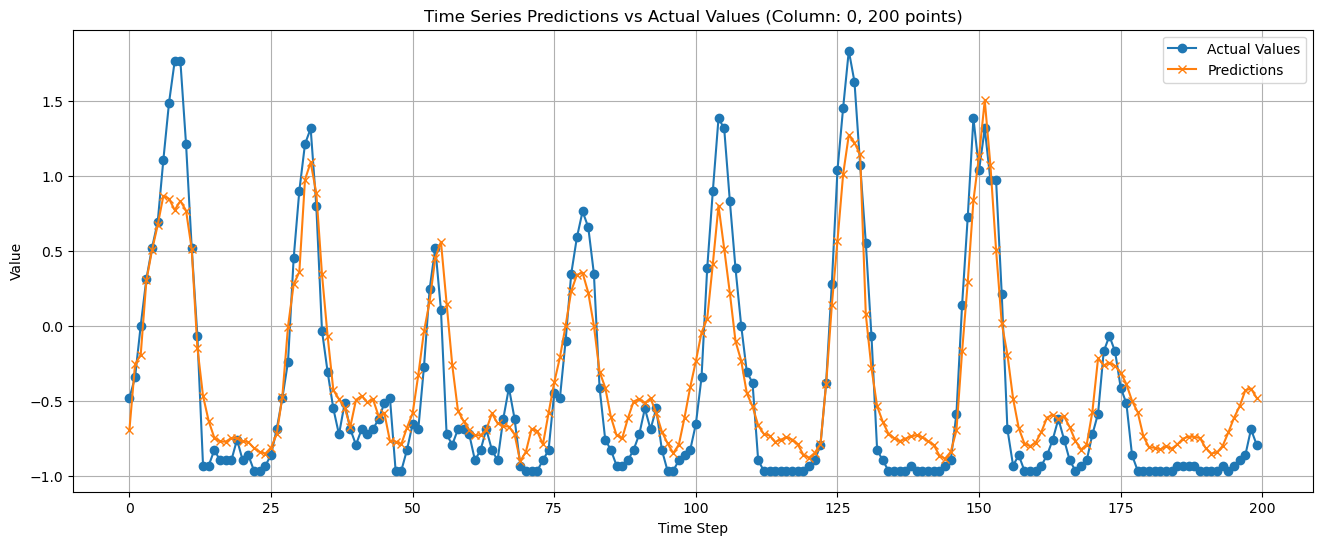

In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already run the code in pytorch_forecast_v2_ar_cleaning.py 
# up to the point where base_predictor is trained and X_df_train_tensor,
# Y_df_train_tensor, sequence_length, and device are defined.

def plot_time_series_predictions(base_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_length, device, num_points=200, target_column_index=0):
    """
    Plots a time series of predictions vs. actual values for a specific column over a sequence of data points.

    Args:
        base_predictor: The trained BasePredictor model.
        X_df_train_tensor: The input data tensor.
        Y_df_train_tensor: The target data tensor.
        sequence_length: The length of the input sequences.
        device: The device to use ('cuda' or 'cpu').
        num_points: The number of data points to include in the time series plot.
        target_column_index: The index of the column in Y_df_train_tensor to plot.
    """
    base_predictor.eval()  # Set the model to evaluation mode

    predictions = []
    actual_values = []
    # Ensure we have enough data points
    total_possible_points = len(X_df_train_tensor) - sequence_length
    if num_points > total_possible_points:
        num_points = total_possible_points
        print(f"Warning: requested {num_points} is larger than total_possible_points: {total_possible_points}, will use {num_points} points")

    with torch.no_grad():
        for i in range(num_points):
            start_idx = i  # Move through the sequence, one step at a time
            
            # Check if the sequence fits in the dataset:
            if start_idx + sequence_length >= len(X_df_train_tensor):
                print(f"skipping sequence with index: {start_idx}, not enough examples in dataset")
                continue

            # Create the input sequence
            input_sequence = X_df_train_tensor[start_idx:start_idx + sequence_length, :]
            input_sequence_flat = input_sequence.reshape(-1).unsqueeze(0).to(device)

            # Make the prediction
            prediction = base_predictor(input_sequence_flat)

            # Get the corresponding actual value for the target column
            actual_value = Y_df_train_tensor[start_idx + sequence_length, target_column_index]

            # Extract the prediction for the target column
            prediction_for_column = prediction[0, target_column_index]

            predictions.append(prediction_for_column.cpu().numpy())
            actual_values.append(actual_value.cpu().numpy())

    # Plotting
    plt.figure(figsize=(16, 6))  # Increased figure size for a longer time series
    plt.plot(actual_values, label='Actual Values', marker='o', linestyle='-')
    plt.plot(predictions, label='Predictions', marker='x', linestyle='-')

    plt.title(f'Time Series Predictions vs Actual Values (Column: {target_column_index}, {num_points} points)')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


# Example Usage:
sequence_length = 6
num_points = 200  # Number of data points to plot
target_column_index = 0  # The column from Y_df_train_tensor to plot
plot_time_series_predictions(base_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_length, device, num_points, target_column_index)

In [27]:
# Instanciar el AutoregressivePredictor con el BasePredictor ya entrenado
input_dim = X_df_train.shape[1]
output_dim = Y_df_train.shape[1]
sequence_length = 6
num_steps = 4

# ar_predictor = AutoregressivePredictor(base_predictor, input_dim, output_dim).to(device)


class AutoregressivePredictor(nn.Module):
    def __init__(self, base_predictor, input_dim, output_dim, sequence_length):
        super(AutoregressivePredictor, self).__init__()
        self.base_predictor = base_predictor
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.sequence_length = sequence_length

    def forward(self, inputs, num_steps):
        predictions = []
        current_input = inputs

        for _ in range(num_steps):
            pred = self.base_predictor(current_input)
            predictions.append(pred)
            current_input = self.update_inputs(current_input, pred)

        return torch.stack(predictions, dim=1)

    def update_inputs(self, inputs, preds):
        # Si quiere mantener la longitud de los inputs
        # Remover los datos más antiguos y agregar el nuevo predicho a la secuencia
        new_inputs = torch.cat((inputs[:, self.input_dim:], preds), dim=1)
        return new_inputs

# Ahora creamos el AutoregressivePredictor
ar_predictor = AutoregressivePredictor(base_predictor, input_dim, output_dim, sequence_length).to(device)

# Define el optimizador para el modelo autoregresivo
optimizer_ar = optim.Adam(ar_predictor.parameters(), lr=0.0005)  # Tasa de aprendizaje diferente
criterion_ar = nn.MSELoss()

ar_predictor.train()  # Establecer el modo de entrenamiento

# Entrenamiento del AutoregressivePredictor
for epoch in range(num_epochs_ar):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:   
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer_ar.zero_grad()
        
        # Realizar una predicción para varios pasos hacia adelante
        outputs = ar_predictor(x_batch, num_steps=num_steps)
        
        # La pérdida es la media de la pérdida para cada uno de los pasos
        loss = criterion_ar(outputs[:, -1, :], y_batch)  # Solo usar el último paso en la secuencia para la pérdida
        
        loss.backward()
        optimizer_ar.step()
        epoch_loss += loss.item()

    # Imprime la pérdida promedio por época cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

Epoch [10/30], Loss: 0.3483


Epoch [20/30], Loss: 0.3391


Epoch [30/30], Loss: 0.3346


In [28]:
input_dim

224

In [29]:
# Definir una secuencia de entrada para evaluar
sequence_start_idx = 0  # Cambia este índice según desees probar diferentes secuencias

# Crear la secuencia de entrada
input_sequence = X_df_train_tensor[sequence_start_idx:sequence_start_idx + sequence_length, :]
# Aplanar la secuencia y añadir dimensión para batch
input_sequence_flat = input_sequence.reshape(-1).unsqueeze(0).to(device)

# Entrena el ar_predictor
ar_predictor.eval()  # Establecer el modo de evaluación

# Realizar la predicción autoregresiva
with torch.no_grad():
    predictions = ar_predictor(input_sequence_flat, num_steps=4)  # Predecir 4 pasos

# Mostrar las predicciones
print("Predicciones:")
for step, prediction in enumerate(predictions.squeeze(0), 1):
    print(f"Paso {step}: {prediction.cpu().numpy()}")

Predicciones:
Paso 1: [-0.7454519  -0.7321379  -0.7277213  -0.8209546  -0.7341568  -0.7225417
 -0.73220146 -0.6202325  -0.8469779  -0.7318595  -0.6666611  -0.7249098
 -0.71659225 -0.78910345 -0.72285974 -0.6180633  -0.6569068  -0.52693105
 -0.6659307  -0.7199397  -0.69092107 -0.6778556  -0.6834304  -0.7285601
 -0.7318234  -0.84657085 -0.7046472  -0.7323035  -0.7259818  -0.74765885
  1.6580813   0.496937    0.4400782   1.7077043   0.36403662  0.49363938
  0.4920411   0.36610475  0.4931017   1.4196813   1.0817738   1.3706061
  0.5152756   0.48432994  0.49350238  0.4942977   0.4971187   0.5384261
  0.48813838  0.49020052  0.46134415  0.31703445  0.74562615  0.51544905
  0.30369914  0.5815878   0.00515583  0.75755596  0.47907108  0.34789455
  0.47720426  0.25668022  0.38000238  0.47574037  0.1527583   0.25980633
  0.15906931  0.36133835  0.42034972  0.4003755   0.5861028   0.39575723
  0.47917104  0.48015183  0.816533    0.36919302  0.47740558  0.35260227
  1.444297    1.451322    1.452405

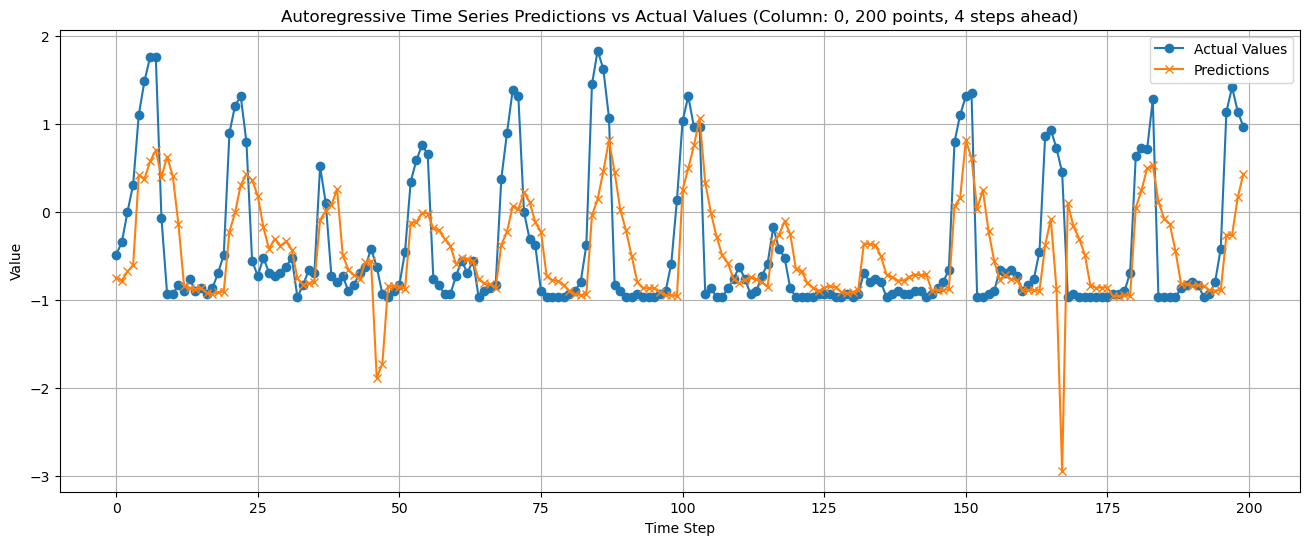

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already run the code in pytorch_forecast_v2_ar_cleaning.py
# up to the point where ar_predictor is trained and X_df_train_tensor,
# Y_df_train_tensor, sequence_length, and device are defined.

def plot_autoregressive_time_series_predictions(ar_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_length, device, num_points=200, target_column_index=0, num_steps_ahead=4):
    """
    Plots a time series of predictions vs. actual values for a specific column using the AutoregressivePredictor.

    Args:
        ar_predictor: The trained AutoregressivePredictor model.
        X_df_train_tensor: The input data tensor.
        Y_df_train_tensor: The target data tensor.
        sequence_length: The length of the input sequences.
        device: The device to use ('cuda' or 'cpu').
        num_points: The number of data points to include in the time series plot.
        target_column_index: The index of the column in Y_df_train_tensor to plot.
        num_steps_ahead: The number of steps ahead the AR predictor will forecast.
    """
    ar_predictor.eval()  # Set the model to evaluation mode

    all_predictions = []
    all_actual_values = []

    # Calculate how many sequences are needed
    num_sequences = int(np.ceil(num_points / num_steps_ahead))
    # Ensure we have enough data points
    total_possible_points = len(X_df_train_tensor) - sequence_length
    if num_sequences*sequence_length > total_possible_points:
        num_sequences = total_possible_points//sequence_length
        print(f"Warning: requested {num_points} is larger than total_possible_points: {total_possible_points}, will use {num_sequences*num_steps_ahead} points")

    with torch.no_grad():
        for i in range(num_sequences):
            start_idx = i*sequence_length  # Move through the sequence
            
            # Check if the sequence fits in the dataset:
            if start_idx + sequence_length >= len(X_df_train_tensor):
                print(f"skipping sequence with index: {start_idx}, not enough examples in dataset")
                continue

            # Create the input sequence
            input_sequence = X_df_train_tensor[start_idx:start_idx + sequence_length, :]
            input_sequence_flat = input_sequence.reshape(-1).unsqueeze(0).to(device)

            # Make the autoregressive prediction
            predictions = ar_predictor(input_sequence_flat, num_steps=num_steps_ahead)
            
            # Get the corresponding actual values for the target column
            # from start_idx + sequence_length for num_steps_ahead
            actual_values = Y_df_train_tensor[start_idx + sequence_length: start_idx + sequence_length + num_steps_ahead, target_column_index]
            

            # Extract the predictions for the target column
            predictions_for_column = predictions[0, :, target_column_index]

            all_predictions.extend(predictions_for_column.cpu().numpy())
            all_actual_values.extend(actual_values.cpu().numpy())

    # Ensure we only keep num_points of the total data
    all_predictions = all_predictions[:num_points]
    all_actual_values = all_actual_values[:num_points]
    # Plotting
    plt.figure(figsize=(16, 6))  # Increased figure size for a longer time series
    plt.plot(all_actual_values, label='Actual Values', marker='o', linestyle='-')
    plt.plot(all_predictions, label='Predictions', marker='x', linestyle='-')

    plt.title(f'Autoregressive Time Series Predictions vs Actual Values (Column: {target_column_index}, {num_points} points, {num_steps_ahead} steps ahead)')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Usage:
sequence_length = 6
num_points = 200  # Number of data points to plot
target_column_index = 0  # The column from Y_df_train_tensor to plot
num_steps_ahead = 4 # the arpredictor has 4 steps
plot_autoregressive_time_series_predictions(ar_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_length, device, num_points, target_column_index, num_steps_ahead)

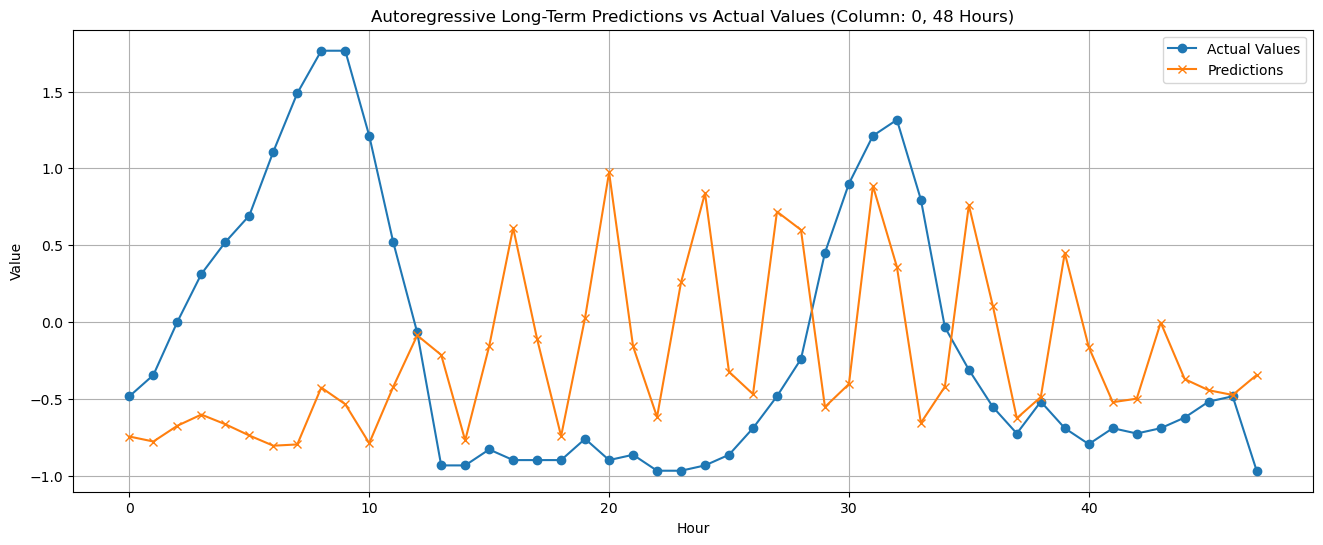

In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already run the code in pytorch_forecast_v2_ar_cleaning.py
# up to the point where ar_predictor is trained and X_df_train_tensor,
# Y_df_train_tensor, sequence_length, and device are defined.

def plot_autoregressive_long_term_predictions(ar_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_length, device, num_hours_to_predict=48, target_column_index=0):
    """
    Plots a long-term time series of autoregressive predictions (e.g., 48 hours) against actual values.

    Args:
        ar_predictor: The trained AutoregressivePredictor model.
        X_df_train_tensor: The input data tensor.
        Y_df_train_tensor: The target data tensor.
        sequence_length: The length of the input sequences.
        device: The device to use ('cuda' or 'cpu').
        num_hours_to_predict: The number of hours to predict into the future (e.g., 48).
        target_column_index: The index of the column in Y_df_train_tensor to plot.
    """
    ar_predictor.eval()  # Set the model to evaluation mode

    all_predictions = []
    all_actual_values = []

    with torch.no_grad():
        # Start at the beginning of the dataset
        start_idx = 0

        # Check if there's enough data to make the full 48-hour prediction
        if start_idx + sequence_length + num_hours_to_predict > len(X_df_train_tensor):
            print(f"Not enough data to predict {num_hours_to_predict} hours. Reducing prediction horizon.")
            num_hours_to_predict = len(X_df_train_tensor) - sequence_length - start_idx
        
        # Create the initial input sequence
        input_sequence = X_df_train_tensor[start_idx:start_idx + sequence_length, :]
        input_sequence_flat = input_sequence.reshape(-1).unsqueeze(0).to(device)
        
        
        current_predictions = []

        # Iterate to predict each step, updating the input for the next step
        for _ in range(num_hours_to_predict):
            # Make a 1-step-ahead prediction
            prediction = ar_predictor.base_predictor(input_sequence_flat)
            
            # Extract the prediction for the target column
            prediction_for_column = prediction[0, target_column_index]
            
            current_predictions.append(prediction_for_column.cpu().numpy())
            
            # Update the input for the next prediction
            input_sequence_flat = ar_predictor.update_inputs(input_sequence_flat, prediction)


        all_predictions.extend(current_predictions)
        # Get the corresponding actual values for the target column
        actual_values = Y_df_train_tensor[start_idx + sequence_length: start_idx + sequence_length + num_hours_to_predict, target_column_index]
        all_actual_values.extend(actual_values.cpu().numpy())

    # Plotting
    plt.figure(figsize=(16, 6))
    plt.plot(all_actual_values, label='Actual Values', marker='o', linestyle='-')
    plt.plot(all_predictions, label='Predictions', marker='x', linestyle='-')

    plt.title(f'Autoregressive Long-Term Predictions vs Actual Values (Column: {target_column_index}, {num_hours_to_predict} Hours)')
    plt.xlabel('Hour')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


# Example Usage:
sequence_length = 6  # Same as during training
num_hours_to_predict = 48  # Predict the next 48 hours
target_column_index = 0  # The column from Y_df_train_tensor to plot

plot_autoregressive_long_term_predictions(ar_predictor, X_df_train_tensor, Y_df_train_tensor, sequence_length, device, num_hours_to_predict, target_column_index)

In [32]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.optim.lr_scheduler import LinearLR

# # ... (Your existing BasePredictor, AutoregressivePredictor, TimeSeriesDataset, etc.) ...

# # ---- Configuration ----
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# input_dim = X_df_train.shape[1]
# output_dim = Y_df_train.shape[1]
# sequence_length = 6
# num_ar_steps = 12  # 72 hours / 6 hours per step = 12 steps

# # ---- Instantiate Models and Dataset ----
# # Create the base predictor
# base_predictor = BasePredictorMultiStep(input_size=input_dim, num_classes=output_dim, sequence_length=sequence_length).to(device)

# # Create the Dataset
# train_dataset = TimeSeriesDatasetMultiStep(X_df_train_tensor, Y_df_train_tensor, sequence_length)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Create the Autoregressive Predictor
# ar_predictor = AutoregressivePredictorMultiStep(base_predictor, input_dim, output_dim, sequence_length).to(device)

# # ---- Training ----
# # Define optimizers and loss functions
# optimizer_base = optim.Adam(base_predictor.parameters(), lr=1e-3)
# optimizer_ar = optim.Adam(ar_predictor.parameters(), lr=5e-7)  # lower learning rate for AR

# criterion = nn.MSELoss()

# # ---- Phase 1: Initial BasePredictor Training (Increasing LR) ----
# num_epochs_phase1 = 10
# print("Training BasePredictor Phase 1...")
# base_predictor.train()
# # Define learning rate scheduler for phase 1
# lr_lambda_phase1 = lambda epoch: (2e-4 + (1e-3 - 2e-4) * epoch / (num_epochs_phase1 - 1))
# scheduler_phase1 = torch.optim.lr_scheduler.LambdaLR(optimizer_base, lr_lambda=lr_lambda_phase1)

# for epoch in range(num_epochs_phase1):
#     epoch_loss = 0.0
#     for x_batch, y_batch in train_loader:
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         optimizer_base.zero_grad()
#         outputs = base_predictor(x_batch)
#         y_batch = y_batch.reshape(y_batch.shape[0], -1)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer_base.step()
#         epoch_loss += loss.item()
#     # Update learning rate
#     scheduler_phase1.step()
    

#     if (epoch + 1) % 1 == 0:
#         print(f'BasePredictor Phase 1 Epoch [{epoch+1}/{num_epochs_phase1}], Loss: {epoch_loss/len(train_loader):.4f}, LR: {optimizer_base.param_groups[0]["lr"]:.6f}')

# # ---- Phase 2: Extended BasePredictor Training (Decreasing LR) ----
# num_epochs_phase2 = 30
# print("Training BasePredictor Phase 2...")
# base_predictor.train()
# # Define learning rate scheduler for phase 2
# lr_lambda_phase2 = lambda epoch: (1e-3 - (1e-3 - 2e-4) * epoch / (num_epochs_phase2 - 1))
# scheduler_phase2 = torch.optim.lr_scheduler.LambdaLR(optimizer_base, lr_lambda=lr_lambda_phase2)

# for epoch in range(num_epochs_phase2):
#     epoch_loss = 0.0
#     for x_batch, y_batch in train_loader:
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         optimizer_base.zero_grad()
#         outputs = base_predictor(x_batch)
#         y_batch = y_batch.reshape(y_batch.shape[0], -1)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer_base.step()
#         epoch_loss += loss.item()
#     # Update learning rate
#     scheduler_phase2.step()

#     if (epoch + 1) % 10 == 0:
#         print(f'BasePredictor Phase 2 Epoch [{epoch+1}/{num_epochs_phase2}], Loss: {epoch_loss/len(train_loader):.4f}, LR: {optimizer_base.param_groups[0]["lr"]:.6f}')

# # ---- Phase 3: Autoregressive Fine-Tuning ----
# num_epochs_phase3 = 10
# print("Training AutoregressivePredictor Phase 3...")
# ar_predictor.train()
# for epoch in range(num_epochs_phase3):
#     epoch_loss = 0.0
#     for x_batch, y_batch in train_loader:
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         optimizer_ar.zero_grad()
#         outputs = ar_predictor(x_batch, num_steps=num_ar_steps) # num_steps = 12
#         outputs = outputs.reshape(y_batch.shape[0], -1)
#         y_batch = y_batch.reshape(y_batch.shape[0], -1)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer_ar.step()
#         epoch_loss += loss.item()

#     if (epoch + 1) % 1 == 0:
#         print(f'AutoregressivePredictor Phase 3 Epoch [{epoch+1}/{num_epochs_phase3}], Loss: {epoch_loss/len(train_loader):.4f}, LR: {optimizer_ar.param_groups[0]["lr"]:.6f}')